Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
# загрузка библиотек:
# операции с массивом данных
import pandas as pd
import numpy as np
# градиентный бустинг
import lightgbm as lgb
from catboost import CatBoostRegressor
# разделение выборки на множества
from sklearn.model_selection import train_test_split, GridSearchCV
# порядковое кодирование
from sklearn.preprocessing import OrdinalEncoder
# метрика качества моделей
from sklearn.metrics import mean_squared_error
# построение графических иллюстраций
import seaborn as sns
import matplotlib.pyplot as plt
# изменение темы диаграмм
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# загрузка массива данных
autos = pd.read_csv('autos.csv')

In [3]:
# просмотр первых пяти наблюдений
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# просмотр общей информации по переменным
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- имеем переменные как с целочисленным форматом `int64`, так и со строковым форматом `object`.
- такие переменные как почтовый индекс владельца `PostalCode`, дата скачивания анкеты `DateCrawled`, месяца регистрации автомобиля `RegistrationMonth`, создания анкеты `DateCreated`, последней активности пользователя `LastSeen` скорее не столь информативны при определении стоимости автомобиля. Удалим данные переменные из матрицы признаков.
- год регистрации автомобиля (`RegistrationYear`) является полезной информацией. Если автомобиль давно зарегистрирован но еще не продан, значит есть причины, побуждающие потенциальных клиентов не приобретать данный актив.
- остальные переменные как пробег (`Kilometer`), марка, мощность (`Power`) весьма полезны при прогнозировании стоимости автомобиля.

In [5]:
# проверим наличие дублированных наблюдений
autos.duplicated().sum()

4

- имеем четыре идентичных наблюдения.

In [6]:
# просмотр дублированных наблюдений
autos.loc[autos.duplicated()==True,:]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [7]:
# удаление дубликатов
autos = autos.drop_duplicates()

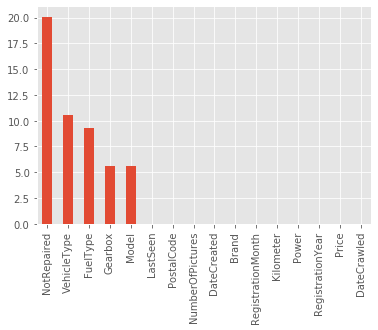

In [8]:
# просмотр процентной доли пропущенных величин по каждой из переменных
(autos.isna().sum().sort_values(ascending=False) / autos.shape[0] * 100).plot(kind='bar')

- по наличию или отсутствию ремонтных работ автомобиля (`NotRepaired`) имеем 20% пропусков. Возможно действительно машина не была в ремонте. Владельцы сочли что по картинке станет ясно что с машиной все в порядке. Поэтому не указано отсутствие ремонта. Однако если машина на самом деле ремонтировалась, то это может оттолкнуть потенциальных клиентов к приобретению 'раненного' автомобиля. Поэтому владельцы не указали наличие ремонта.
- пропуски по типу кузова (`VehicleType`), типу топлива (`FuelType`), коробке передач (`GearBox`) и модели автомобиля (`Model`) могут объясняться техническими ошибками при заполнении. Ведь владельцы периодически сталкиваются с заправкой и ремонтированием автомобиля. Это побуждает к изучению базовых характеристик машины.

In [9]:
# создадим список столбцов, по которым есть пропущенные наблюдения
cols_with_na = ['NotRepaired','VehicleType','FuelType','Gearbox','Model']

In [10]:
# Построим функцию, которая отображает гистограмму распределения цен на автомобиль 
# в разрезе характеристики машины, по которой отсутствуют наблюдения
def plot_price_na(data, feature, bins=10, density=False):
    '''
    data: массив данных
    feature: признак машины, в разрезе которого строится гистограмма распределения цен на автомобиль
    bins: количество корзин разбиения гистограммы
    density: индикаторная переменная для построения гистограммы плотностей
    '''
    # построение простой гистограммы
    if density==False:
        # изменим тип отображения гистограммы
        data.loc[data[feature].isna()==True,'Price'].plot(kind='hist', bins=bins, lw=4, figsize=(12,8), 
                                                          histtype='step',label=feature, legend=True)
    # построение гистограммы плотностей
    else:
        data.loc[data[feature].isna()==True, 'Price'].plot(kind='hist', density=density, figsize=(12,8),
                                                           histtype='step', lw=4,
                                                           label=feature, legend=True)

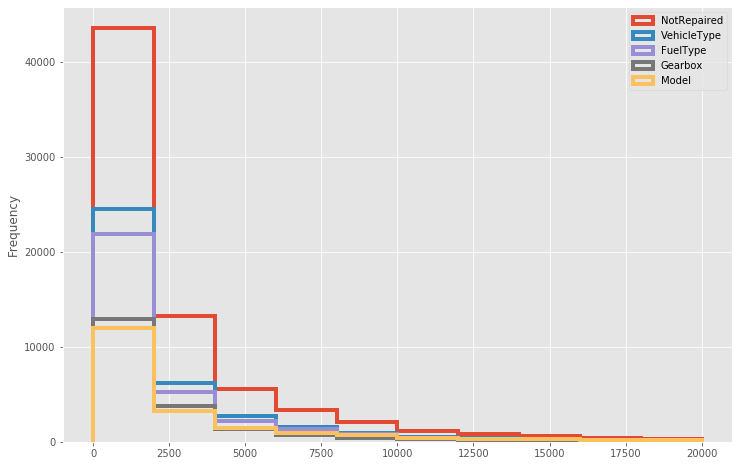

In [11]:
# По характеристикам, у которых есть пропущенные наблюдения построим гистограмму распределения цен на автомобиль 
for feature in cols_with_na:
    plot_price_na(autos, feature)

- пропущенные наблюдения в основном имеются по автомобилям, стоимость которых не превышает 5000 у.е.
- наверное и поэтому отсутствует информация по наличию ремонта. Так как ремонт говорит о менее качественном автомобиле, что и снижает его стоимость. В целом, распределение цен на автомобиль для пропущенных наблюдений по пяти характеристикам скошено влево, с толстым правым хвостом.
- Восстановить наличие/отсутствие ремонта (`NotRepaired`) на основе имеющейся информации весьма трудно. Так как ремонту подвергаются все виды машин: новые, старые; дешевые, дорогие; более престижной и более простой марки.
- Заполнение пропущенных наблюдений по типу кузова, топлива, коробки передач также весьма тяжело. Это объясняется обширным множеством комбинаций одних характеристик машины с другими: автомобили с автоматической коробкой передач могут принимать практически любые значения из перечня типа кузова, модели. Аналогичная ситуация и по другим техническим характеристикам автомобиля.

In [12]:
# весьма интересной переменной является "количество фотографий". 
# Большое количество фотографий может отражать сильное желание продать автомобиль
# При малом числе фотографий, владелец может показать лишь лучшие стороны автомобиля
autos['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

- отсутствуют фотографии по автомобилям из выборочной совокупности.

In [13]:
# создадим список переменных, имеющие малую значимость
cols_to_drop = ['Price', 'DateCrawled','RegistrationMonth','DateCreated',
                'LastSeen','PostalCode','NumberOfPictures']

In [14]:
# Определим матрицу характеристик автомобилей
features = autos.drop(labels=cols_to_drop, axis=1)
# Определим вектор целевых величин - стоимость автомобиля
target = autos['Price']

In [15]:
# просмотр первых пяти наблюдений матрицы признаков
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [16]:
# создадим словарь переменных, которые имеют числовые значения
num_features_dict = {'RegistrationYear':'год_регистрации','Power':'мощность_л_с','Kilometer':'пробег_км'}
# создадим словарь переменных, которые имеют категориальные значения
cat_features_dict = {'VehicleType':'тип_кузова','Gearbox':'тип_коробки_передач',
                     'Model':'модель_авто','FuelType':'тип_топлива',
                     'NotRepaired':'наличие_ремонта','Brand':'марка_авто'}

#### Приступим к преобразованию переменных с числовыми значениями.

In [17]:
# определим последнюю дату (1) создания анкеты, (2) скачивания анкеты, 
# (3) последней активности владельца автомобиля.
# Это поможет скорректировать год регистрации автомобиля.
print('Максимальное значение:')
for key, value in {'DateCreated':'дата_создания_анкеты',
                   'DateCrawled':'дата_скачивания_анкеты',
                   'LastSeen':'дата_последней_активности'}.items():
    print('{:-^30}'.format(value))
    print(autos[key].max())
    print()

Максимальное значение:
-----дата_создания_анкеты-----
2016-04-07 00:00:00

----дата_скачивания_анкеты----
2016-04-07 14:36:58

--дата_последней_активности---
2016-04-07 14:58:51



- 2016 год является последним годом в выборочной совокупности.

In [18]:
# Определим функцию, которая отображает (1) гистограмму плотностей, (2) ящик с усами для заданной переменной
def dens_hist_and_box(data, feature):
    '''
    data: массив данных
    feature: переменная по которой строятся диаграммы
    '''
    # определим два подграфика
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    # на первом подграфике отображена гистограмма плотностей распределения
    data[feature].plot(ax=axes[0], kind='hist', density=True)
    # на втором - ящик с усами
    data[feature].plot(ax=axes[1], kind='box')
    plt.tight_layout()

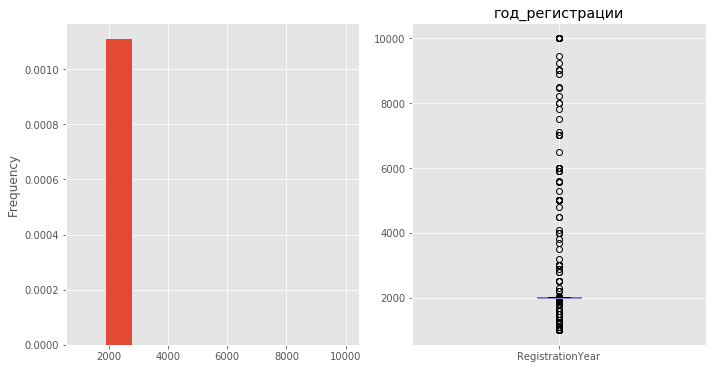

---год_регистрации----
count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64



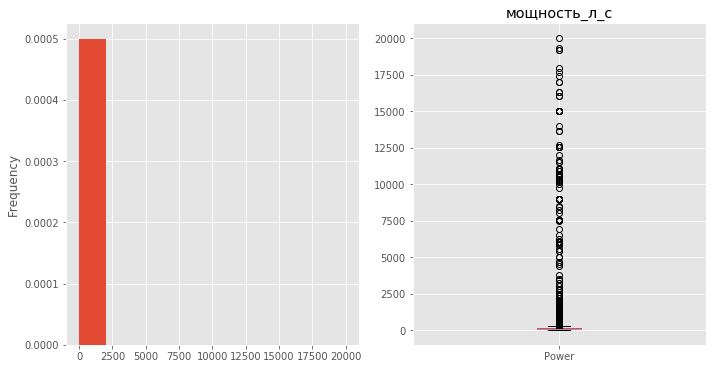

-----мощность_л_с-----
count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64



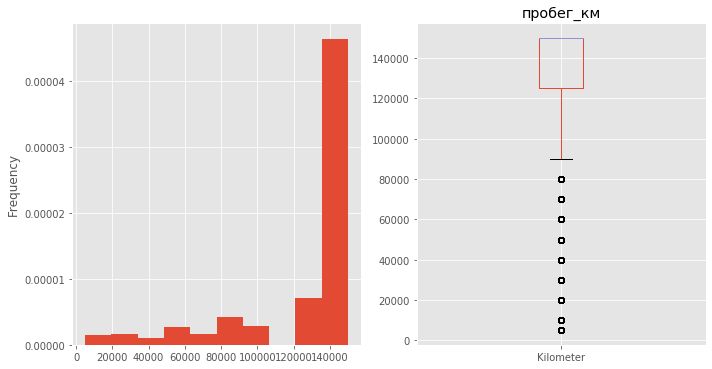

------пробег_км-------
count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64



In [19]:
# Для переменных, имеющие количественные значения построим гистограмму плотностей и ящик с усами
for key, value in num_features_dict.items():
    dens_hist_and_box(features, key)
    # отображение заголовка диаграммы
    plt.title(value)
    # отображение диаграмм
    plt.show()
    # Определим числовые характеристики переменных
    print('{:-^22}'.format(value))
    print(features[key].describe())
    print()

- **год регистрации**: 
- минимальное и максимальное значение не может принимать 1000 и 9999, соответственно.
- если приравнаяем все что больше 2016 к 2016-ти, то можем неправильно увеличить значимость 2016 года (год последней регистрации и активности владельцев автомобилей из выборки).
- правдоподобным является 25-й процентиль года регистрации. Он датируется 1999 годом.
- правдоподобным является 75-й процентиль года регистрации. Он датируется 2008 годом.
- **мощность (лошадиные силы)**:
- минимальное и максимальное значение не может принимать 0 и 20 000, соответственно.
- весьма правдоподобным является 75-й процентиль равный 143 л.с. Приравняем мощность, которая превышает 143 л.с. на величину 75-го процентиля.
- **пробег (км)**:
- минимальное и максимальное значения принимают правдоподобные величины: 5000 и 150 000 км. Однако, 50-й, 75-й процентиль равен максмальной величине. Возможно возникли ошибки при заполнении значений. Может быть случайно добавлен ноль в переменной "пробег". Например, вместо фактических 12 500 км указано 125 000 км. А это повышает количество машин с большим пробегом.

In [20]:
# Определим нижний предел межквартильного размаха пробега автомобилей по формуле "Q1 - 1.5 (Q3 - Q1)"
print(
    features['Kilometer']\
    .describe()['25%'] - 
    1.5*(features['Kilometer'].describe()['75%'] -
         features['Kilometer'].describe()['25%'])
)

87500.0


In [21]:
# Определим функцию, которая удаляет записи с некорректными значениями для трех переменных:
# (1) год регистрации RegistrationYear, (2) пробег Kilometer, (3) мощность двигателя Power.
# Пропущенные наблюдения заполняются меткой "unknown". 
# Заполнение пропусков модой может привести к смещению результатов на последующих этапах исследования.
def clean_outliers(data):
    '''
    data: массив данных, где необходимо удалить выбивающиеся наблюдения.
    Пропущенные наблюдения заполняются меткой "unknown".
    output: удаление записей в некорректными значениями
    '''
    # удаление выбивающихся наблюдений
    data = data.query('1999 <= RegistrationYear <= 2016')
    data = data.query('Kilometer >= 87500')
    data = data.query('Power <= 143')
    # удаление пропущенных наблюдений
    data = data.fillna(value='unknown')
    # возвращаем массив, где удалили выбивающиеся наблюдения
    return data

In [22]:
# Апробация функции clean_outliers на матрице признаков
features = clean_outliers(features)

### Промежуточные выводы
- имеем 354 369 наблюдений. Каждый автомобиль имеем 16 характеристик.
- есть пропущенные наблюдений. Большинство, скорее, обусловлено техническими ошибками при заполнении, так как по базовым характеристикам автомобиля владельцы, вероятнее всего, осведомлены. 
- пропущенные наблюдения заполняются меткой `unknown`.
- в матрицу признаков не включены следующие переменные: почтовый индекс владельца `PostalCode`, дата скачивания анкеты `DateCrawled`, месяца регистрации автомобиля `RegistrationMonth`, создания анкеты `DateCreated`, последней активности пользователя `LastSeen`.
- удалены 4 дублированных наблюдения.
- удалены выбивающиеся значения в трех переменных: год регистрации `RegistrationYear`, мощность `Power`, пробег автомобиля `Kilometer`.

In [23]:
# инициализация кодирования
oe = OrdinalEncoder()

In [24]:
cat_list = list(cat_features_dict.keys())
print(cat_list)
features[cat_list] = oe.fit_transform(features[cat_list])
features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
3,5.0,2001,1.0,75,112.0,150000,6.0,38.0,0.0
4,5.0,2008,1.0,69,98.0,90000,2.0,31.0,0.0
6,1.0,2004,1.0,109,7.0,150000,6.0,25.0,0.0
10,4.0,2004,1.0,105,9.0,150000,6.0,19.0,0.0
11,8.0,2005,1.0,140,166.0,150000,2.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...
354360,8.0,2005,1.0,3,10.0,150000,2.0,2.0,0.0
354363,0.0,2000,1.0,0,241.0,150000,6.0,24.0,0.0
354364,7.0,2005,1.0,0,75.0,150000,6.0,22.0,2.0
354366,1.0,2000,0.0,101,103.0,125000,6.0,32.0,0.0


In [25]:
# Создадим новый массив данных. Значения в новом массиве - закодированные значения категориальные признаков.
# Перенесем столбцы и индексы матрицы признаков features на новый массив oe_values.
oe_values = pd.DataFrame(data=oe.fit_transform(features[cat_features_dict.keys()]),
                         columns=list(cat_features_dict.keys()),
                         index=features.index)

In [26]:
# вывод первых пяти наблюдений массива закодированных значений категориальных признаков
oe_values.head()

,VehicleType,Gearbox,Model,FuelType,NotRepaired,Brand
3,5.0,1.0,112.0,6.0,0.0,38.0
4,5.0,1.0,98.0,2.0,0.0,31.0
6,1.0,1.0,7.0,6.0,0.0,25.0
10,4.0,1.0,9.0,6.0,0.0,19.0
11,8.0,1.0,166.0,2.0,2.0,38.0


In [27]:
# Объединим новый массив категориальных признаков oe_values с переменными, значения которых имеют числовой формат.
features = features[num_features_dict.keys()].join(oe_values)

In [28]:
# вывод первых пяти наблюдений матрицы признаков с учетом кодирования категориальных признаков
features.head()

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,NotRepaired,Brand
3,2001,75,150000,5.0,1.0,112.0,6.0,0.0,38.0
4,2008,69,90000,5.0,1.0,98.0,2.0,0.0,31.0
6,2004,109,150000,1.0,1.0,7.0,6.0,0.0,25.0
10,2004,105,150000,4.0,1.0,9.0,6.0,0.0,19.0
11,2005,140,150000,8.0,1.0,166.0,2.0,2.0,38.0


In [29]:
# Воспользуемся исключениями при удалении лишнего массива закодированных категориальных данных oe_values
try:
    del oe_values
except:
    print('При удалении oe_values возникла ошибка')
else:
    print('Массив категориальных данных oe_values удален')

Массив категориальных данных oe_values удален


# 2. Обучение моделей

In [30]:
# 80% наблюдений исходной выборки отнесем к тренировочному множеству,
# остальные 20% наблюдений приходятся на тестовое множество
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            features.join(target)['Price'],
                                                                           test_size=0.20, random_state=42)

In [31]:
# Функция gbm_train формирует модель на основе LightGBM. 
# Далее, подбирает гиперпараметры через GridSearchCV.
# Квадрат среднеквадратической ошибки вычисляется на основе фактической стоимости автомобиля тестового множества
# и предсказаний оптимальной модели LightGBM.
def gbm_train(features_train, target_train, features_test, target_test,
             min_n_estimators=100, max_n_estimators=121, n_estimators_step=10, 
             min_num_leaves=30, max_num_leaves=33, num_leaves_step=2, cv=5):
    '''
    Функция возращает квадрат среднеквадратической ошибки по оптимальной модели LightGBM.
    feature_train, target_train: матрица признаков, вектор целевых значений обучающего множества
    features_test, target_test: матрица признаков, вектор целевых значений тестового множества
    min_n_estimators, max_n_estimators: минимальное, максимальное количество деревьев
    n_estimators_step: шаг количества деревьев
    min_num_leaves, max_num_leaves: минимальное, максимальное количество листьев деревьев
    num_leaves_step: шаг количества листьев деревьев
    cv: количество блоков кросс-валидации
    '''
    # Инициализация модели
    gbm = lgb.LGBMRegressor(boosting_type='gbdt',random_state=42, 
                        cat_features=list(features.select_dtypes('float64').columns))
    # формирование сетки гиперпараметров
    grid_gbm_params = {'learning_rate':np.arange(0.5,1,0.1),
                   'n_estimators':np.arange(100,121,10),
                   'num_leaves':np.arange(30,33,2)}
    # формирование множества моделей
    grid_gbm =  GridSearchCV(estimator=gbm, param_grid=grid_gbm_params,
                         scoring='neg_mean_squared_error',cv=cv, n_jobs=-1)
    # обучение моделей
    grid_gbm.fit(features_train, target_train)
    # на основе оптимальной модели вычисляем прогнозные значения стоимости автомобилей
    gbm_pred = grid_gbm.best_estimator_.predict(features_test)
    # возвращаем квадрат среднеквадратической ошибки в контексте тестового множества
    return mean_squared_error(target_test, gbm_pred) ** 0.5

In [32]:
list(features.select_dtypes('float64').columns)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']

## Промежуточные выводы
- из выборочной совокупности выделены тренировочное и тестовое множества.
- функция `gbm_train` обучает модели на основе `LightGBMRegressor`. 

# 3. Анализ моделей

In [34]:
%time gbm_rmse = gbm_train(features_train, target_train, features_test, target_test)

CPU times: user 6.62 s, sys: 524 ms, total: 7.15 s
Wall time: 37.1 s


In [39]:
# Вывод информации по оптимальной модели
gbm_train

<function __main__.gbm_train(features_train, target_train, features_test, target_test, min_n_estimators=100, max_n_estimators=121, n_estimators_step=10, min_num_leaves=30, max_num_leaves=33, num_leaves_step=2, cv=5)>

In [37]:
# Вывод квадрата среднеквадратического отклонения по оптимальной модели
gbm_rmse

1271.0466145836485